Convolutional Neural Network by Marlo Esperson


Raytheon Advisors: David Detienne and Kerry Courtright

Faculty Advisor: Alex Orange

Team Members: Josh Miraglia, Ryan Procarione, and Erik Graham

Last Update: 2.02.2022 

The purpose of this program is to take in labeled generated signal data (bandwidth, center frequency, and signal-to-noise ratio (SNR)) from a Massive MIMO antenna and use it to train and test a convolutional neural network model that will be able to estimate bandwidth, center frequency, time, and SNR parameters.


Read in all signal data and labels:

In [54]:
#plotting function
%matplotlib notebook

In [55]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os

#spec = 2048

#M = 9999 # number of signals

#filein = "/local/2048_Angles_First.h5"

filein = "/mnt/nndataset/experiment1/run1x1/CNN_dataset.hdf5"

with h5py.File(filein, "r") as f:
    folders = f.keys()
    data = f.get('signals/rx_signals')
    
    #print(data.keys())
   # print(data['labels/signals'])
    items = list(f.items())
    print('Items in directory:', items)
    a1 = f.get('labels')
    a1_items = list(a1.items())
    print('Label items:', a1_items)
    
    
    ######
    signal_data = data[0]
    gen_sigs = np.array(signal_data)
    #print(data.keys())
    
    print(signal_data.shape)
    
    bandwidth = np.array(f.get('labels/bandwidth'))
    centerf = np.array(f.get('labels/center_freq'))
    
    #print(np.max(SNR)) 
    SNR = np.array(f.get('labels/SNR')) # standard deviation np.std deviation (?) or divide by largest number np.max(SNR)
    SNR_sf = np.max(SNR)
    print(SNR_sf)
    SNR = SNR/SNR_sf
   # print(np.max(SNR)) 
    
    start = np.array(f.get('labels/start_index'))/2048
    stop = np.array(f.get('labels/end_index'))/2048
    
    
    #SNR = SNR/(np.std(SNR))  
    
    #data = np.array(S.get('rx_signals'))
    #dataset = data[0,0,:,:] #Sets the last two dimensions of the 4 dimensional array as the main 
                            #dataset
   

    #print(L.keys())
    #print(dataset.shape)
    #bandwidth = np.array(L.get('bandwidth'))
    #centers = np.array(L.get('center_freq')) #TODO: include frequency in name
    #SNR = np.array(L.get('SNR'))
    

Items in directory: [('description', <HDF5 dataset "description": shape (1,), type "|O">), ('labels', <HDF5 group "/labels" (6 members)>), ('metadata', <HDF5 group "/metadata" (6 members)>), ('signals', <HDF5 group "/signals" (4 members)>)]
Label items: [('SNR', <HDF5 dataset "SNR": shape (29951,), type "<f8">), ('bandwidth', <HDF5 dataset "bandwidth": shape (29951,), type "<f8">), ('center_freq', <HDF5 dataset "center_freq": shape (29951,), type "<f8">), ('end_index', <HDF5 dataset "end_index": shape (29951,), type "<f8">), ('modulation', <HDF5 dataset "modulation": shape (29951,), type "|O">), ('start_index', <HDF5 dataset "start_index": shape (29951,), type "<f8">)]
(29951, 2048)
40.19734009146633


# Move bandwidth labeled data into an array:

<IPython.core.display.Javascript object>


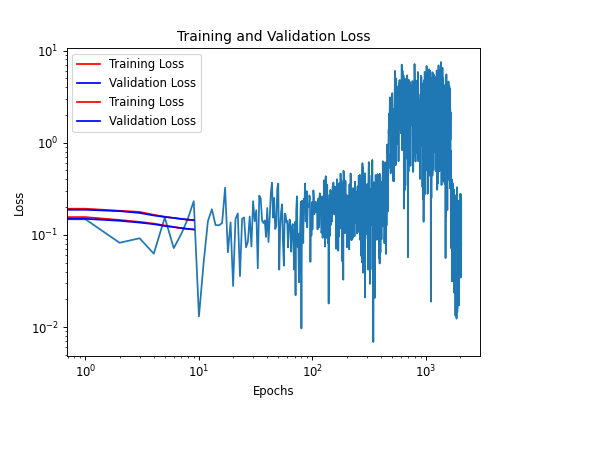

In [56]:
dataset_fft = abs(np.fft.fftshift(np.fft.fft(gen_sigs), (1,))) #Pass this into NN.
plt.plot(abs(dataset_fft[20]))
plt.show()
#dataset_fft = abs(gen_sigs) #Pass this into NN.

# Creates a list
inputdata = np.array([dataset_fft, gen_sigs])
np.shape(inputdata)
inputdata = np.swapaxes(inputdata, 0, 1)
np.shape(inputdata)
inputdata = np.swapaxes(inputdata, 2, 1)

Move center frequency labeled data into array:

Splitting Dataset into Training and Testing Data

In [66]:
import os
num_threads = 24
os.environ["OMP_NUM_THREADS"] = "24"
os.environ["TF_NUM_INTRAOP_THREADS"] = "24"
os.environ["TF_NUM_INTEROP_THREADS"] = "24"

import tensorflow as tf

#config = tf.ConfigProto(intra_op_parallelism_threads=24,
#                        inter_op_parallelism_threads=2,
#                        allow_soft_placement=True,
#                        device_count = {'CPU': 24})
#session = tf.Session(config=config)
tf.config.threading.set_intra_op_parallelism_threads(24)
tf.config.threading.set_inter_op_parallelism_threads(24)
tf.config.set_soft_device_placement(True)

#from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D
import sys
import h5py
import random
import datetime

#Casts a list indexing from 0 to 9999 for each labeled dataset
#Bandwidth
#print(len(bandwidth))
# idx_bw = list(range(len(bandwidth)))
idx = list(range(len(centerf)))


#Center Frequency
#idx_cf = list(range(len(centers)))
#Signal-to-Noise Ratio
#idx_SNR = list(range(len(SNR)))



#Shuffles indices of bandwidth, center freq, and SNR datasets
# random.shuffle(idx_bw)


# Ramdom seed 3700 is shuffling data correctly (omitted seed (5) due to it not shuffling)
random.Random(3700).shuffle(idx)


#Splitting datasets (8000 assigned to training and 2000 to testing)
# training_indices_bw, testing_indices_bw = np.split(idx_bw, [int(0.8*len(idx_bw))])
training_indices, testing_indices = np.split(idx, [int(0.8*len(idx))])



training_data = []
training_labels = []
testing_data = []
testing_labels = []




for idx in training_indices:
    #iterate through all indices and print
    training_data.append(inputdata[idx])
    training_labels.append([start[idx], stop[idx], bandwidth[idx], SNR[idx], centerf[idx]])
    #   print(idx)

    #put bandwidth training_data and training_labels into a numpy array.
training_data = tf.convert_to_tensor(np.array(training_data), dtype=tf.float32)
training_labels = tf.convert_to_tensor(np.array(training_labels), dtype=tf.float32)
#training_labels_bw = tf.reshape(training_labels_bw, training_labels_bw.get_shape()+(1,))
   
for idx in testing_indices:
    testing_data.append(inputdata[idx])
    testing_labels.append([start[idx], stop[idx], bandwidth[idx], SNR[idx], centerf[idx]])
    #

testing_data = tf.convert_to_tensor(np.array(testing_data), dtype=tf.float32)
testing_labels = tf.convert_to_tensor(np.array(testing_labels), dtype=tf.float32)
    


print(np.shape(training_data))
print(np.shape(training_labels))


print(np.max(training_labels))

# training_data = np.array(training_data)
# training_labels = np.array(training_labels)

# testing_data = np.array(testing_data)
# testing_labels = np.array(testing_labels)



/local/dev/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


(23960, 2048, 2)
(23960, 5)
1.0


In [73]:
from tensorflow import keras
#from tensorflow.keras.layers import Conv2D

finput = tf.keras.layers.Input(shape = (2048, 2), name = "finput") #2 dimensions
##Conv1D(number of kernels (try as few as 4 and go up by factors of 2, NoMachine?),
##length of the kernel (per discussion on board, try around 300), relu may not be the best, try other activation functions)
##Conv1D(How many kernels, points that define the kernels, activation....)

flayer1 = Conv1D(filters=64/2, kernel_size = 3, activation="tanh", name = "flayer1")(finput)
flayer1 = MaxPooling1D(2, name = "fPool1")(flayer1)

flayer2 = Conv1D(filters=128/2, kernel_size = 3, activation = "tanh", name = "flayer2")(flayer1)
flayer2 = MaxPooling1D(2, name = "fPool2")(flayer2)

flayer3 = Conv1D(filters=256/2, kernel_size = 3, activation = "tanh", name = "flayer3")(flayer2)
flayer3 = MaxPooling1D(2, name = "fPool3")(flayer3)

flayer4 = Conv1D(filters= 512/2, kernel_size = 3, activation = "tanh", name = "flayer4")(flayer3)
flayer4 = MaxPooling1D(2, name = "fPool4")(flayer4)   

flayer5 = Flatten(name = "fFlatten")(flayer4)

flayer6 = Dense(64, activation = "tanh", name = "fDense1")(flayer5)

foutput = Dense(5, activation = "tanh", name = "fDense2")(flayer6)


model = tf.keras.models.Model(inputs = finput, outputs = foutput)
model.summary()

#opt = keras.optimizers.Adam(learning_rate = 0.00000001)

opt = keras.optimizers.Adam(learning_rate = 0.000001)

#Johnathan Wintrode
model.compile(loss='mean_squared_error', optimizer = opt)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
finput (InputLayer)          [(None, 2048, 2)]         0         
_________________________________________________________________
flayer1 (Conv1D)             (None, 2046, 32)          224       
_________________________________________________________________
fPool1 (MaxPooling1D)        (None, 1023, 32)          0         
_________________________________________________________________
flayer2 (Conv1D)             (None, 1021, 64)          6208      
_________________________________________________________________
fPool2 (MaxPooling1D)        (None, 510, 64)           0         
_________________________________________________________________
flayer3 (Conv1D)             (None, 508, 128)          24704     
_________________________________________________________________
fPool3 (MaxPooling1D)        (None, 254, 128)          0   

Training the Network

In [ ]:
print(training_data_cf)

In [6]:
# training_data_bw = tf.data.Dataset.from_tensor_slices(training_data_bw)
# training_labels_bw = tf.data.Dataset.from_tensor_slices(training_labels_bw)
# testing_data_bw = tf.data.Dataset.from_tensor_slices(testing_data_bw)
# testing_labels_bw = tf.data.Dataset.from_tensor_slices(testing_labels_bw)

training_data_cf = tf.data.Dataset.from_tensor_slices(training_data_cf)
training_labels_cf = tf.data.Dataset.from_tensor_slices(training_labels_cf)
testing_data_cf = tf.data.Dataset.from_tensor_slices(testing_data_cf)
testing_labels_cf = tf.data.Dataset.from_tensor_slices(testing_labels_cf)

training_data_start = tf.data.Dataset.from_tensor_slices(training_data_start)
training_labels_start = tf.data.Dataset.from_tensor_slices(training_labels_start)
testing_data_start = tf.data.Dataset.from_tensor_slices(testing_data_start)
testing_labels_start = tf.data.Dataset.from_tensor_slices(testing_labels_start)

training_data_stop = tf.data.Dataset.from_tensor_slices(training_data_stop)
training_labels_stop = tf.data.Dataset.from_tensor_slices(training_labels_stop)
testing_data_stop = tf.data.Dataset.from_tensor_slices(testing_data_stop)
testing_labels_stop = tf.data.Dataset.from_tensor_slices(testing_labels_stop)

In [7]:
# training_data_bw, training_labels_bw
training_data_cf, training_labels_cf
training_data_start, training_labels_start
training_data_stop, training_labels_stop

(<TensorSliceDataset shapes: (2048,), types: tf.float32>,
 <TensorSliceDataset shapes: (), types: tf.float32>)

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# # Question: Can I add more than just training_data_bw and training_labels_bw in the parameters below ????????
# training_data = tf.data.Dataset.zip((training_data_bw, training_labels_bw))
# print(training_data)
# training_data = training_data.batch(128)
# print(training_data)
# training_data = training_data.cache()
# print(training_data)
# training_data = training_data.prefetch(tf.data.AUTOTUNE)
# print(training_data)


# testing_data = tf.data.Dataset.zip((testing_data_bw, testing_labels_bw))
# testing_data = testing_data.batch(128)
# testing_data = testing_data.cache()
# testing_data = testing_data.prefetch(tf.data.AUTOTUNE)

# training_data

In [8]:
training_data_cf = tf.data.Dataset.zip((training_data_cf, training_labels_cf))
print(training_data_cf)
training_data_cf = training_data_cf.batch(128)
print(training_data_cf)
training_data_cf = training_data_cf.cache()
print(training_data_cf)
training_data_cf = training_data_cf.prefetch(tf.data.AUTOTUNE)
print(training_data_cf)


testing_data_cf = tf.data.Dataset.zip((testing_data_cf, testing_labels_cf))
testing_data_cf = testing_data_cf.batch(128)
testing_data_cf = testing_data_cf.cache()
testing_data_cf = testing_data_cf.prefetch(tf.data.AUTOTUNE)

training_data_cf

<ZipDataset shapes: ((2048,), ()), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float32)>
<CacheDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float32)>


<PrefetchDataset shapes: ((None, 2048), (None,)), types: (tf.float32, tf.float32)>

In [ ]:
# training_data_start = tf.data.Dataset.zip((training_data_start, training_labels_start))
# print(training_data_start)
# training_data_start = training_data_start.batch(128)
# print(training_data_start)
# training_data_start = training_data_start.cache()
# print(training_data_start)
# training_data_start = training_data_start.prefetch(tf.data.AUTOTUNE)
# print(training_data_start)


# testing_data_start = tf.data.Dataset.zip((testing_data_start, testing_labels_start))
# testing_data_start = testing_data_start.batch(128)
# testing_data_start = testing_data_start.cache()
# testing_data_start = testing_data_start.prefetch(tf.data.AUTOTUNE)

# training_data_start

In [ ]:
# training_data_stop = tf.data.Dataset.zip((training_data_stop, training_labels_stop))
# print(training_data_stop)
# training_data_stop = training_data_stop.batch(128)
# print(training_data_stop)
# training_data_stop = training_data_stop.cache()
# print(training_data_stop)
# training_data_stop = training_data_stop.prefetch(tf.data.AUTOTUNE)
# print(training_data_stop)


# testing_data_stop = tf.data.Dataset.zip((testing_data_stop, testing_labels_stop))
# testing_data_stop = testing_data_stop.batch(128)
# testing_data_stop = testing_data_stop.cache()
# testing_data_stop = testing_data_stop.prefetch(tf.data.AUTOTUNE)

# training_data_stop

In [ ]:
#training, default batch size is 1/32 of the dataset
#TODO: increase epochs later to see differences in loss and val_loss
#history = model.fit(training_data, training_labels, epochs = 10, validation_data = (testing_data, testing_labels), callbacks=[tensorboard_callback])
#I like the results for 1500 epochs (1/10/2021)
#history = model.fit(training_data, epochs=3000, validation_data=testing_data)

#How many epochs to perform?



In [74]:
filepath = "/local/models/marlomodel.h5"
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='max',
    save_best_only=True)
history_cf = model.fit(training_data, training_labels, epochs=10, validation_data=(testing_data,testing_labels), callbacks = [callback] )

Epoch 1/10
749/749 [==============================] - 18s 24ms/step - loss: 0.0960 - val_loss: 0.0282
Epoch 2/10
749/749 [==============================] - 18s 23ms/step - loss: 0.0257 - val_loss: 0.0223
Epoch 3/10
749/749 [==============================] - 17s 23ms/step - loss: 0.0217 - val_loss: 0.0202
Epoch 4/10
749/749 [==============================] - 18s 24ms/step - loss: 0.0194 - val_loss: 0.0185
Epoch 5/10
749/749 [==============================] - 18s 24ms/step - loss: 0.0180 - val_loss: 0.0171
Epoch 6/10
749/749 [==============================] - 18s 24ms/step - loss: 0.0162 - val_loss: 0.0156
Epoch 7/10
749/749 [==============================] - 18s 24ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 8/10
749/749 [==============================] - 18s 24ms/step - loss: 0.0142 - val_loss: 0.0140
Epoch 9/10
749/749 [==============================] - 18s 23ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 10/10
749/749 [==============================] - 18s 24ms/step - loss: 0.013

In [ ]:
#history_start = model.fit(training_data_start, epochs=1000, validation_data=testing_data_start)

In [ ]:
#history_stop = model.fit(training_data_stop, epochs=1000, validation_data=testing_data_stop)

In [75]:
loss = model.evaluate(testing_data, batch_size=128)
print("test loss, test acc:", loss)
print(loss)
print(history_cf.history)

#mean square
loss = history_cf.history['loss']
val_loss = history_cf.history['val_loss']
#epochs = range(1,9)


#Root mean square
sqrt_loss = np.sqrt(loss)
sqrt_val_loss = np.sqrt(val_loss)

plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

47/47 [==============================] - 0s 511us/step - loss: 0.0000e+00
test loss, test acc: 0.0
0.0
{'loss': [0.054377373307943344, 0.024283483624458313, 0.02104703150689602, 0.01912812702357769, 0.0175529345870018, 0.01600865088403225, 0.014793554320931435, 0.01397934090346098, 0.013415900990366936, 0.012933912687003613], 'val_loss': [0.028239209204912186, 0.022303830832242966, 0.020230719819664955, 0.018480440601706505, 0.017078330740332603, 0.015621655620634556, 0.014781287871301174, 0.01399354450404644, 0.013476314954459667, 0.013224562630057335]}


In [76]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels)-1)

print("Index value:", random_index)

predict_cf = model.predict(testing_data)

print("Inferred value:", predict_cf[random_index])
print("Actual value:", testing_labels[random_index])

predict_list = predict_cf[random_index].tolist()
testing_list = testing_labels[random_index].tolist()
#print("test", predict_list[0])
#print(np.max(testing_data[random_index]))

# output: bw, SNR, cf

plt.figure()
num_frequencies = signal_data.shape[1]
start_frequency = -0.5
stop_frequency = (num_frequencies // 2 - 1) / num_frequencies
plt.plot(np.linspace(start_frequency, stop_frequency, num_frequencies),
         abs(testing_data[random_index]))

plt.vlines((predict_list[2]), 0, np.max(testing_data[random_index]), colors = "r", linestyles = "dashed", label = 'Predicted Center Freq')
plt.vlines((testing_list[2]), 0, np.max(testing_data[random_index]), colors = "k", linestyles = "solid", label = 'Actual Center Freq')
plt.legend()
plt.title('RX Signal')
plt.ylabel('Signal Magnitude')
plt.xlabel('Frequency')

plt.show()

plt.savefig("cf2.svg", format = "svg")

Index value: 1349
Inferred value: [ 0.39603478  0.8336412   0.54966956  0.3001477  -0.0213637 ]
Actual value: tf.Tensor([0.11474609 0.88671875 0.682112   0.25800884 0.0281748 ], shape=(5,), dtype=float32)


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'tolist'

In [ ]:
#model.save('Time_Freq_CNN.h5')


<IPython.core.display.Javascript object>


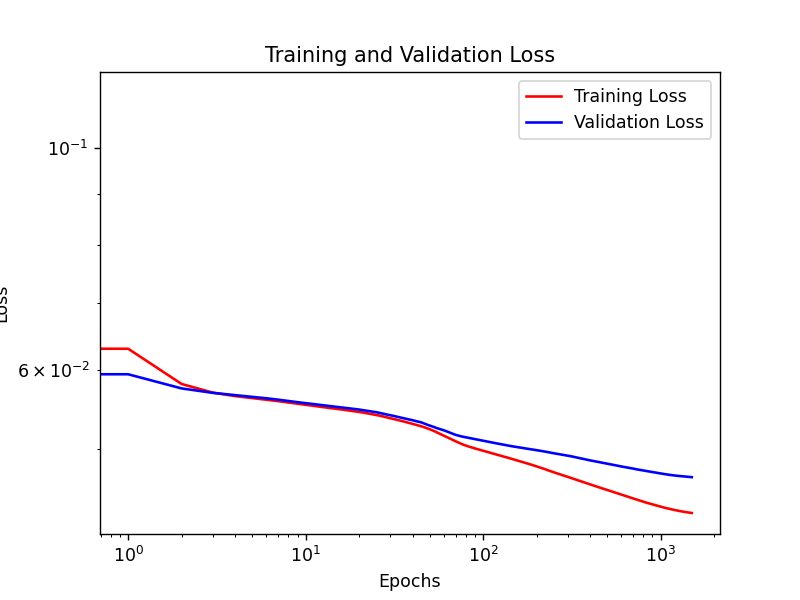

In [11]:
plt.figure()
plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [2]:
#Random integer input for checking random indices.

random_index = random.randint(0,len(testing_labels_cf)-1)

print("Index value:", random_index)

predict_cf = model.predict(testing_data_cf)

print("Inferred value:", predict_cf[random_index])
#print("Actual value:", testing_labels_cf[random_index])
print(centerf[random_index])

NameError: name 'random' is not defined

In [13]:
print(centerf[1058])

0.0285496


In [ ]:
loss_cf = model.evaluate(testing_data_cf, batch_size=128)
print("test loss, test acc:", loss_cf)
print(loss_cf)
print(history_cf.history)

#mean square
loss_cf = history_cf.history['loss']
val_loss_cf = history_cf.history['val_loss']
#epochs = range(1,9)


#Root mean square
sqrt_loss = np.sqrt(loss_cf)
sqrt_val_loss = np.sqrt(val_loss_cf)

In [ ]:
plt.figure()
plt.loglog(sqrt_loss, 'r', label='Training Loss')
plt.loglog(sqrt_val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#tf.config.list_physical_devices()